In [1]:
import pandas as pd
import numpy as np
import os
import sys
import datetime
import time

#from netCDF4 import Dataset, num2date
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor,GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, MaxAbsScaler,Normalizer
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import adjusted_rand_score, r2_score
from sklearn.feature_selection import mutual_info_regression

import matplotlib.dates as mdates
import matplotlib.colors
import matplotlib.ticker as ticker

from pysolar.solar import *
import pytz
import shap
import pickle
import multiprocessing

from sklearn.decomposition import PCA, FastICA
from sklearn.random_projection import GaussianRandomProjection

RANDOM_STATE = 42
n_jobs = multiprocessing.cpu_count()

# Perameters


In [59]:
cheap_node_list = ['001e063059c2', '001e06305a61', '001e06305a6c', '001e06318cd1',
                   '001e06323a05', '001e06305a57', '001e06305a6b', '001e06318c28',
                   '001e063239e3', '001e06323a12']

cheap_node_id = '001e06305a61'#'001e06305a6b'
node_id = '10004098'
gps_node_id = '001e0610c2e9'
dir_out = '../figures/' + cheap_node_id + '/'
dir_data = '../data/'

years = ['2019','2020'] ####
months = ['1','2','3','4','5','6','7','8','9','10','11','12']
days = np.array(range(1,31+1)).astype(str) #### np.array(range(1,31+1)).astype(str)
days = list(days)

hours = (np.array(range(0,24))).astype(str)
hours = list(hours)

bins = np.array(range(0,420+1)).astype(str)
bins = list(bins)
for i in range(len(bins)):
    bins[i] = 'Spectrum[' + bins[i] + ']'

wavelengths = np.array(range(360,780+1))#.astype(str)
#for i in range(len(wavelengths)):
#    wavelengths[i] = wavelengths[i] + 'nm'
#wavelengths = list(wavelengths)

## Read Data

In [60]:
# if data has been preprocessed before, run this directly
fn_data = dir_data + node_id + '_'+ cheap_node_id +'.csv'
df = pd.read_csv(fn_data, parse_dates=True, index_col = 'UTC')
df = df[(df.index.date != datetime.date(2019, 12, 31)) # Minolta was covered in these dates
       &(df.index.date != datetime.date(2019, 12, 27))
       &(df.index.date != datetime.date(2020,  1,  1))
       &(df.index.date != datetime.date(2020,  1,  2))]
#        &(df.index.date != datetime.date(2020, 2, 14))
#        &(df.index.date != datetime.date(2020, 2, 21))] 

In [604]:
df['altitude'].median()

/Users/Strawberry/opt/miniconda3/envs/geo_env/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


207.84

In [61]:
features = [#'cloudPecentage', 'allRed', 'allGreen', 'allBlue',
            #'skyRed', 'skyGreen', 'skyBlue', 'cloudRed', 'cloudGreen', 'cloudBlue',
            'Violet', 'Blue', 'Green', 'Yellow', 'Orange', 'Red',
            'Temperature', 'Pressure', 'Humidity',
            #'Latitude', 'Longitude', 'Altitude',
            #'NH3', 'CO', 'NO2', 'C3H8', 'C4H10', 'CH4', 'H2', 'C2H5OH', 'CO2',
            'Luminosity', 'IR', 'Full', 'Visible', 'Lux',
            'UVA', 'UVB', 'Visible Compensation','IR Compensation', 'UV Index',
            'Zenith','Azimuth','Sun Distance']
features = np.array(features)
num_features = len(features)
num_features

20

In [62]:
targets = df.columns[-421-1:-1].values # skip Illuminance, keep Wavelengths
print(features)
print(targets[[0,-1]])

X = df[features]
Y = df[targets] # MLP and scaler use multi output

['Violet' 'Blue' 'Green' 'Yellow' 'Orange' 'Red' 'Temperature' 'Pressure'
 'Humidity' 'Luminosity' 'IR' 'Full' 'Visible' 'Lux' 'UVA' 'UVB'
 'Visible Compensation' 'IR Compensation' 'UV Index' 'Zenith']
['360nm' '780nm']


## Prepare Data  For Training

In [63]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

# scale the data
scaler_x = StandardScaler()
X_train_scaled = scaler_x.fit_transform(X_train)
X_test_scaled = scaler_x.transform(X_test)

scaler_y = StandardScaler()
Y_train_scaled = scaler_y.fit_transform(Y_train)
Y_test_scaled = scaler_y.transform(Y_test)


In [64]:
n_components = 18

DR = 'PCA'
Cluster = 'None'
pca = PCA(n_components=n_components, random_state = RANDOM_STATE)

X_train_scaled_DR = pca.fit_transform(X_train_scaled)
X_test_scaled_DR = pca.transform(X_test_scaled)

X_train_scaled_DR = pd.DataFrame(X_train_scaled_DR)
X_test_scaled_DR = pd.DataFrame(X_test_scaled_DR)
print(pca.explained_variance_)

# save pca model
dir_DR = '../models/' + cheap_node_id + '/'
if not os.path.exists(dir_DR):
    os.mkdir(dir_DR)

fn_DR = dir_DR + DR + '.sav'
pickle.dump(pca, open(fn_DR, 'wb'))

[1.33414171e+01 2.05997133e+00 1.52437682e+00 1.12177688e+00
 8.15919621e-01 4.07837161e-01 2.77228425e-01 2.19439807e-01
 1.58587829e-01 3.86038689e-02 1.69833759e-02 8.81164952e-03
 6.66789046e-03 1.30353751e-03 8.46560884e-04 2.80503487e-04
 2.53534842e-05 4.60578821e-06]


In [65]:
scaler_x2 = StandardScaler()
X_train_scaled_DR_scaled = scaler_x2.fit_transform(X_train_scaled_DR)
X_test_scaled_DR_scaled = scaler_x2.transform(X_test_scaled_DR)

# Model Start from here

## Model for Whole Spectrum

In [66]:
# for hidden_layer_sizes in [(128,128),
#                            (64,64,64,64),
#                            (32,32,32,32,32),
#                            (512),
#                            (256),
#                            (256,256)
#                           ]:
#     print(hidden_layer_sizes)
#     activation ='relu'
#     solver = 'adam'
#     alpha=1e-5 # L2 penalty (regularization term) parameter
#     learning_rate = 'constant'

#     # include layer structure and activation function
#     structure = '_' + DR + str(n_components) + \
#                 '_' + str(hidden_layer_sizes)[1:-1].replace(', ','_') + \
#                 '_' + activation
    
#     start_time = time.time()
#     regr = MLPRegressor(random_state=RANDOM_STATE,
#                         hidden_layer_sizes=hidden_layer_sizes,
#                         activation = activation,
#                         solver = solver,
#                         alpha = alpha,
#                         learning_rate = learning_rate,
#                         verbose = False
#                         )
#     regr.fit(X_train_scaled_DR_scaled, Y_train_scaled)

#     print("--- %s seconds ---" % (time.time() - start_time))
    
#     # save model
#     dir_model = '../models/' + cheap_node_id + '/'
#     if not os.path.exists(dir_model):
#         os.mkdir(dir_model)
#     dir_model += 'whole/'
#     if not os.path.exists(dir_model):
#         os.mkdir(dir_model)

#     fn_model = dir_model + 'MLP_whole' + structure + '.sav'
#     pickle.dump(regr, open(fn_model, 'wb'))
    
    
#     # plot 10 % of the data
#     Y_train_pred = scaler_y.inverse_transform(
#                         regr.predict( X_train_scaled_DR_scaled )
#                         ) # for train
#     Y_test_pred = scaler_y.inverse_transform(
#                         regr.predict( X_test_scaled_DR_scaled )
#                         )# for image
#     #Y_test_pred = regr.predict(X_test) # for test score

#     train_score =  r2_score(Y_train, Y_train_pred)
#     test_score = r2_score(Y_test, Y_test_pred)

#     y_min = np.amin(Y_train.values)
#     y_max = np.amax(Y_train.values)
#     y_line = np.linspace(y_min,y_max,100)

#     plt.rcParams["figure.figsize"] = (8, 8) # (w, h)
#     plt.rcParams.update({'font.size': 20})
#     fig, ax = plt.subplots()
#     plt.plot(y_line,y_line, '-k', label='y=x')

#     length_sample = len(Y_test)//10
#     plt.scatter(Y_train[:length_sample],Y_train_pred[:length_sample], s=1, c = 'blue',label = 'Train, R$^{2}$ ='+str(train_score)[:6])
#     plt.scatter(Y_test[:length_sample],Y_test_pred[:length_sample], s=1, c = 'red', label = 'Test, R$^{2}$ ='+str(test_score)[:6])
#     plt.xlim((y_min,y_max))
#     plt.ylim((y_min,y_max))
#     ax.set_title('Predicted vs Actual for Whole Spectrum')
#     ax.set_xlabel('Actual Value')
#     ax.set_ylabel('Predicted Value')
#     plt.legend( loc='lower right')
#     plt.grid()
#     plt.tight_layout()

#     if not os.path.exists(dir_out + 'whole'):
#         os.mkdir(dir_out + 'whole')
#     plt.savefig(dir_out + 'whole' +'/MLP_performance_whole'+structure+'.png')


In [67]:
hidden_layer_sizes=(64,128,256)
#hidden_layer_sizes=(128,128,128,128)
#hidden_layer_sizes=(512, 512, 256, 256)
#hidden_layer_sizes=(128,128,128,128,128,128)
#hidden_layer_sizes=(128,128,128,128,128)

activation ='relu'
solver = 'adam'
alpha=1e-5 # L2 penalty (regularization term) parameter, default 1e-5
learning_rate = 'constant'

# include layer structure and activation function
structure = '_' + DR + str(n_components) + \
            '_' + str(hidden_layer_sizes)[1:-1].replace(', ','_') + \
            '_' + activation

In [68]:
start_time = time.time()

regr = MLPRegressor(random_state = RANDOM_STATE,
                    hidden_layer_sizes = hidden_layer_sizes,
                    activation = activation,
                    solver = solver,
                    alpha = alpha,
                    learning_rate = learning_rate,
                    verbose = True
                    )
regr.fit(X_train_scaled_DR_scaled, Y_train_scaled)

# fine tune the model
regr.warm_start = True
regr.learning_rate_init /= 10 # default 0.001
regr.fit(X_train_scaled_DR_scaled, Y_train_scaled)

regr.learning_rate_init /= 10 # default 0.001
regr.fit(X_train_scaled_DR_scaled, Y_train_scaled)
print("--- %s seconds ---" % (time.time() - start_time))

Iteration 1, loss = 0.01357354
Iteration 2, loss = 0.00248569
Iteration 3, loss = 0.00192250
Iteration 4, loss = 0.00158704
Iteration 5, loss = 0.00136126
Iteration 6, loss = 0.00123755
Iteration 7, loss = 0.00114942
Iteration 8, loss = 0.00107020
Iteration 9, loss = 0.00104487
Iteration 10, loss = 0.00098027
Iteration 11, loss = 0.00095396
Iteration 12, loss = 0.00090918
Iteration 13, loss = 0.00087335
Iteration 14, loss = 0.00086064
Iteration 15, loss = 0.00083345
Iteration 16, loss = 0.00081430
Iteration 17, loss = 0.00079162
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 18, loss = 0.00057677
Iteration 19, loss = 0.00055093
Iteration 20, loss = 0.00054149
Iteration 21, loss = 0.00053536
Iteration 22, loss = 0.00052911
Iteration 23, loss = 0.00052329
Iteration 24, loss = 0.00051956
Iteration 25, loss = 0.00051321
Iteration 26, loss = 0.00050940
Iteration 27, loss = 0.00050587
Iteration 28, loss = 0.00050069
Iteration 29, loss = 0.

In [69]:
# save model
dir_model = '../models/' + cheap_node_id + '/'
if not os.path.exists(dir_model):
    os.mkdir(dir_model)
dir_model += 'whole/'
if not os.path.exists(dir_model):
    os.mkdir(dir_model)

fn_model = dir_model + 'MLP_whole' + structure + '.sav'
pickle.dump(regr, open(fn_model, 'wb'))


In [70]:
dir_model = '../models/' + cheap_node_id + '/'  + 'whole/'
fn_model = dir_model + 'MLP_whole' + structure + '.sav'
regr = pickle.load(open(fn_model, 'rb'))


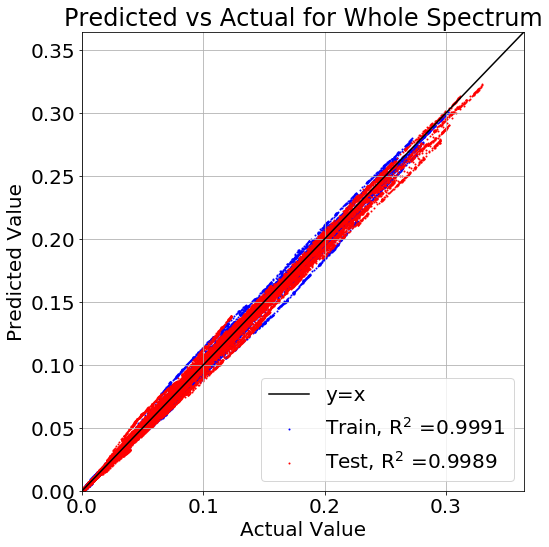

In [71]:
from sklearn.metrics import r2_score

Y_train_pred = scaler_y.inverse_transform(
                    regr.predict( X_train_scaled_DR_scaled )
                    ) # for train
train_score = r2_score(Y_train, Y_train_pred)

Y_test_pred = scaler_y.inverse_transform(
                    regr.predict( X_test_scaled_DR_scaled )
                    )# for test
test_score = r2_score(Y_test, Y_test_pred)

# flatten
Y_train_flatten = Y_train.values.flatten()
Y_train_pred_flatten = Y_train_pred.flatten()

Y_test_flatten = Y_test.values.flatten()
Y_test_pred_flatten = Y_test_pred.flatten()

Y_min = np.min(Y_train_flatten)
Y_max = np.mean(Y_train_flatten) + 5*np.std(Y_train_flatten)

y_line = np.linspace(Y_min,Y_max,100)


plt.rcParams["figure.figsize"] = (8, 8) # (w, h)
plt.rcParams.update({'font.size': 20})
fig, ax = plt.subplots()
plt.plot(y_line,y_line, '-k', label='y=x')

id_train = np.random.choice(len(Y_train_flatten), 5000, replace = False)
plt.scatter(Y_train_flatten[id_train],Y_train_pred_flatten[id_train], s=3, c = 'blue',label = 'Train, R$^{2}$ ='+str(train_score)[:6])
id_test = np.random.choice(len(Y_test_flatten), 5000, replace = False)
plt.scatter(Y_test_flatten[id_test],Y_test_pred_flatten[id_test], s=3, c = 'red', label = 'Test, R$^{2}$ ='+str(test_score)[:6])
plt.xlim(Y_min, Y_max)
plt.ylim(Y_min, Y_max)

ax.set_title('Predicted vs Actual for Whole Spectrum')
ax.set_xlabel('Actual Value')
ax.set_ylabel('Predicted Value')
plt.legend( loc='lower right')
plt.grid()
plt.tight_layout()

if not os.path.exists(dir_out + 'whole'):
    os.mkdir(dir_out + 'whole')
plt.savefig(dir_out + 'whole' +'/MLP_performance_whole'+structure+'.png')


{datetime.date(2019, 12, 26): 3545,
 datetime.date(2020, 1, 23): 786,
 datetime.date(2020, 2, 7): 203,
 datetime.date(2020, 1, 27): 271,
 datetime.date(2020, 1, 31): 922,
 datetime.date(2020, 2, 21): 1414,
 datetime.date(2020, 1, 8): 128,
 datetime.date(2020, 2, 14): 3483,
 datetime.date(2020, 1, 24): 351,
 datetime.date(2020, 2, 1): 537,
 datetime.date(2020, 1, 29): 34,
 datetime.date(2020, 2, 26): 410,
 datetime.date(2020, 1, 28): 136,
 datetime.date(2020, 2, 20): 1190,
 datetime.date(2020, 3, 24): 12,
 datetime.date(2020, 3, 21): 7,
 datetime.date(2019, 12, 29): 125,
 datetime.date(2019, 12, 10): 12,
 datetime.date(2020, 3, 19): 59,
 datetime.date(2020, 3, 1): 7}

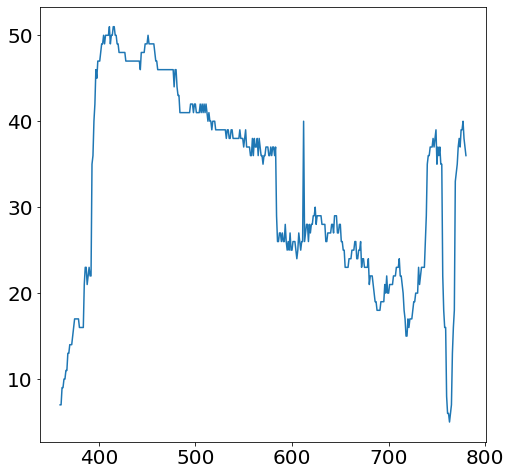

In [72]:
bads = {}
bads_var = {}
counts = []
for i in range(len(targets)):
    var = targets[i]
    temp = Y_train[var][ (Y_train[var]/Y_train_pred[:,i] > 1.2 ) & (Y_train[var]>0.05)]
    # count bad dates
    for date in temp.index.date:
        if date in bads:
            bads[date] += 1
        else:
            bads[date] = 1
    # count bad wavelengths
    var_i = int(var[:-2])
    
    bads_var[var_i] = len(temp)
    counts.append(len(temp))
        

display(bads)


plt.plot(wavelengths, counts)


In [73]:
train_scores = []
test_scores = []
for i in range(len(wavelengths)):
    train_scores.append( r2_score(Y_train.iloc[:,i], Y_train_pred[:,i]) )
    test_scores.append( r2_score(Y_test.iloc[:,i], Y_test_pred[:,i]) )


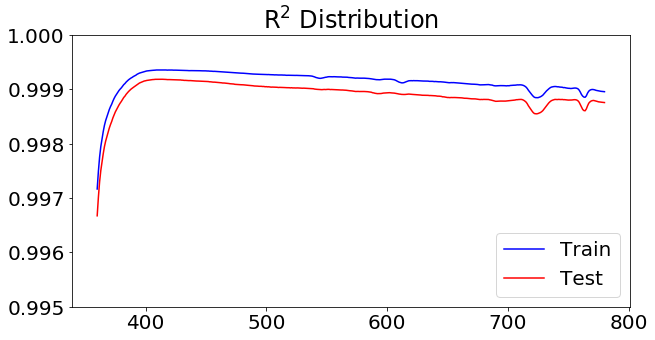

In [74]:
plt.rcParams["figure.figsize"] = (10, 5) # (w, h)
plt.plot(np.array(range(360,780+1)),train_scores, 'b', label = 'Train')
plt.plot(np.array(range(360,780+1)),test_scores, 'r', label = 'Test')
plt.ylim(0.995,1)
plt.title("R$^2$ Distribution")
plt.legend( loc='lower right')
plt.savefig(dir_out + 'whole' + '/MLP_R2' + structure + '.png')


In [75]:
# Create object that can calculate shap values
num_shap = 100
explainer = shap.KernelExplainer(regr.predict, X_train_scaled_DR_scaled[:num_shap])
# Calculate shap_values
shap_values_DR_multi = explainer.shap_values(X_train_scaled_DR_scaled[:num_shap])
shap_values_DR = np.mean(shap_values_DR_multi, axis = 0)

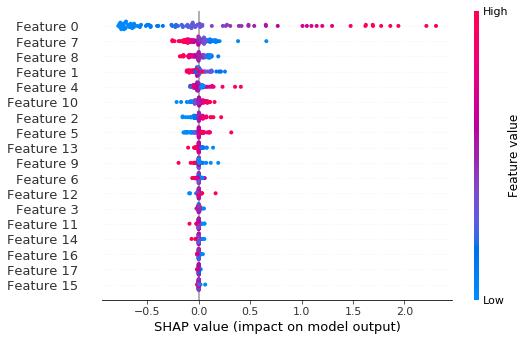

In [76]:
# plot
max_display = n_components
shap.summary_plot(shap_values_DR, X_train_scaled_DR_scaled[:num_shap],
                  plot_size=(8,max_display/3.5),#'auto'
                  max_display = max_display,
                  show=False,
                 )
plt.tight_layout()
plt.savefig(dir_out + 'whole' + '/MLP_shap' + DR + '_whole' + structure + '.png')

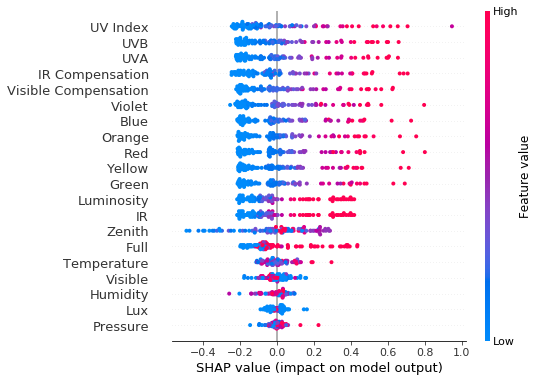

In [77]:
# plot
max_display = num_features
shap_values = pca.inverse_transform(shap_values_DR)
shap.summary_plot(shap_values, X_train_scaled[:num_shap],
                  feature_names = features,
                  plot_size=(8,max_display/3.5),#'auto'
                  max_display = max_display,
                  show=False
                 )
plt.tight_layout()
plt.savefig(dir_out + 'whole' + '/MLP_shap_'+ 'whole' +structure+'.png')

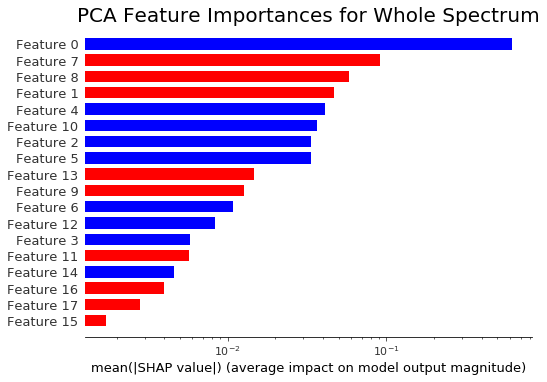

In [78]:
importances_DR = np.mean(np.abs(shap_values_DR), axis = 0)
indices = np.argsort(importances_DR)

# color positive/negative impact blue/red
colormap = {1:'blue',-1:'red', 0:'grey'}
sign = np.array([])
for i in range(n_components):
    sign_i = np.sign(np.corrcoef(X_train_scaled_DR_scaled[:,i], Y_train_scaled.mean(axis = 1))[0,1])
    sign = np.append(sign, sign_i)

sign = sign[indices]
color = [colormap[x] for x in sign]

shap.summary_plot(shap_values_DR, X_train_scaled_DR_scaled[:num_shap],
                  plot_size=(8,max_display/3.5),#'auto'
                  color = color,
                  max_display = max_display,
                  show = False,
                  plot_type = 'bar'
                 )

plt.xscale("log")
plt.title(DR + ' Feature Importances for Whole Spectrum', fontsize = 20)
plt.tight_layout()
plt.savefig(dir_out + 'whole' + '/MLP_'+DR+'Importances_' + 'whole' + structure +'.png')


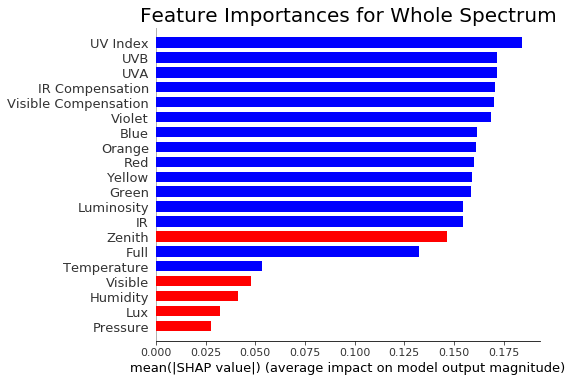

In [79]:
importances = np.mean(np.abs(shap_values), axis = 0)
indices = np.argsort(importances)

# color positive/negative impact blue/red
colormap = {1:'blue',-1:'red', 0:'grey'}
sign = np.array([])
for i in range(num_features):
    sign_i = np.sign(np.corrcoef(X_train_scaled[:,i], Y_train_scaled.mean(axis = 1))[0,1])
    sign = np.append(sign, sign_i)

sign = sign[indices]
color = [colormap[x] for x in sign]

shap.summary_plot(shap_values, X_train_scaled[:num_shap],
                  feature_names = features,
                  plot_size=(8,max_display/3.5),#'auto'
                  color = color,
                  max_display = max_display,
                  show = False,
                  plot_type = 'bar'
                 )

#plt.xscale("log")
plt.title('Feature Importances for Whole Spectrum', fontsize = 20)
plt.tight_layout()
plt.savefig(dir_out + 'whole' + '/MLP_Importances_' + 'whole' + structure +'.png')

## Compare Full Spectrum with Prediction

In [102]:
X_test[X_test.index.date == datetime.date(2020, 3, 5)]

Violet   Blue  Green  Yellow  Orange    Red  Temperature  \
UTC                                                                             
2020-03-05 23:09:40   340.0  434.0  381.0   373.0   246.0  232.0        22.03   
2020-03-05 21:41:00   435.0  525.0  452.0   444.0   289.0  261.0        22.53   
2020-03-05 18:48:00   443.0  521.0  440.0   429.0   275.0  241.0        19.70   
2020-03-05 20:07:30   452.0  535.0  456.0   447.0   289.0  257.0        20.80   
2020-03-05 23:07:00   347.0  441.0  385.0   378.0   250.0  235.0        22.06   
...                     ...    ...    ...     ...     ...    ...          ...   
2020-03-05 13:26:40   204.0  278.0  247.0   239.0   160.0  160.0        10.29   
2020-03-05 14:56:30   396.0  483.0  414.0   400.0   260.0  231.0        13.10   
2020-03-05 13:32:40   229.0  306.0  270.0   262.0   175.0  171.0        10.36   
2020-03-05 18:15:30   438.0  514.0  433.0   421.0   269.0  235.0        18.54   
2020-03-05 00:21:10    11.0   15.0   11.0    11.0     7.0    8.0        12.64   

                     Pressure  Humidity    Luminosity       IR     Full  \
UTC                                                                       
2020-03-05 23:09:40   99769.0      34.0  1.325990e+09  20232.0  65535.0   
2020-03-05 21:41:00   99744.0      33.0  1.493238e+09  22784.0  65535.0   
2020-03-05 18:48:00   99775.0      37.0  1.426915e+09  21772.0  65535.0   
2020-03-05 20:07:30   99740.0      34.0  1.481507e+09  22605.0  65535.0   
2020-03-05 23:07:00   99762.0      34.0  1.338638e+09  20425.0  65535.0   
...                       ...       ...           ...      ...      ...   
2020-03-05 13:26:40   99571.0      76.0  9.182785e+08  14011.0  53632.0   
2020-03-05 14:56:30   99718.0      58.0  1.366622e+09  20852.0  65535.0   
2020-03-05 13:32:40   99583.0      76.0  9.749716e+08  14876.0  58043.0   
2020-03-05 18:15:30   99788.0      36.0  1.390281e+09  21213.0  65535.0   
2020-03-05 00:21:10   99115.0      85.0  5.085896e+07    776.0   3023.0   

                     Visible          Lux     UVA     UVB  \
UTC                                                         
2020-03-05 23:09:40  45303.0    -1.000000  1289.0  1359.0   
2020-03-05 21:41:00  42751.0    -1.000000  1572.0  1646.0   
2020-03-05 18:48:00  43763.0    -1.000000  1593.0  1664.0   
2020-03-05 20:07:30  42930.0    -1.000000  1621.0  1692.0   
2020-03-05 23:07:00  45110.0    -1.000000  1304.0  1376.0   
...                      ...          ...     ...     ...   
2020-03-05 13:26:40  39621.0  1592.303200  1060.0  1145.0   
2020-03-05 14:56:30  44683.0    -1.000000  1649.0  1758.0   
2020-03-05 13:32:40  43167.0  1746.436500  1145.0  1234.0   
2020-03-05 18:15:30  44322.0    -1.000000  1575.0  1647.0   
2020-03-05 00:21:10   2247.0    90.858788    35.0    38.0   

                     Visible Compensation  IR Compensation  UV Index  \
UTC                                                                    
2020-03-05 23:09:40                 442.0            124.0     -0.01   
2020-03-05 21:41:00                 550.0            143.0     -0.01   
2020-03-05 18:48:00                 569.0            136.0     -0.02   
2020-03-05 20:07:30                 574.0            142.0     -0.02   
2020-03-05 23:07:00                 448.0            125.0     -0.01   
...                                   ...              ...       ...   
2020-03-05 13:26:40                 340.0            132.0      0.00   
2020-03-05 14:56:30                 571.0            160.0     -0.01   
2020-03-05 13:32:40                 372.0            137.0      0.00   
2020-03-05 18:15:30                 563.0            133.0     -0.02   
2020-03-05 00:21:10                   7.0              0.0      0.01   

                        Zenith  
UTC                             
2020-03-05 23:09:40  74.769258  
2020-03-05 21:41:00  57.970850  
2020-03-05 18:48:00  38.701424  
2020-03-05 20:07:30  44.028200  
2020-03-05 23:07:00  74.238139  
...                        ..

In [ ]:
from wavelength_to_rgb import wavelength_to_rgb
clim=(350,780)
norm = plt.Normalize(*clim)
wl = np.arange(clim[0],clim[1]+1,2)
colorlist = list(zip(norm(wl),[wavelength_to_rgb(w) for w in wl]))
spectralmap = matplotlib.colors.LinearSegmentedColormap.from_list("spectrum", colorlist)

In [116]:
year = 2020
month = 3
day = 29
hour = 19
minute = 32
second = 40
jetlag = 6
date_string = '%04d-%02d-%02d %02d:%02d:%02d' % (year, month, day, hour, minute, second)
date_string


'2020-03-29 19:32:40'

In [117]:
wavelengths = np.array(range(360,780+1))

iwant = (X_test.index== date_string)
X1 = X_test_scaled_DR_scaled[iwant]
Y1 = Y_test[iwant].values
Y1_pred = scaler_y.inverse_transform(regr.predict(X1))

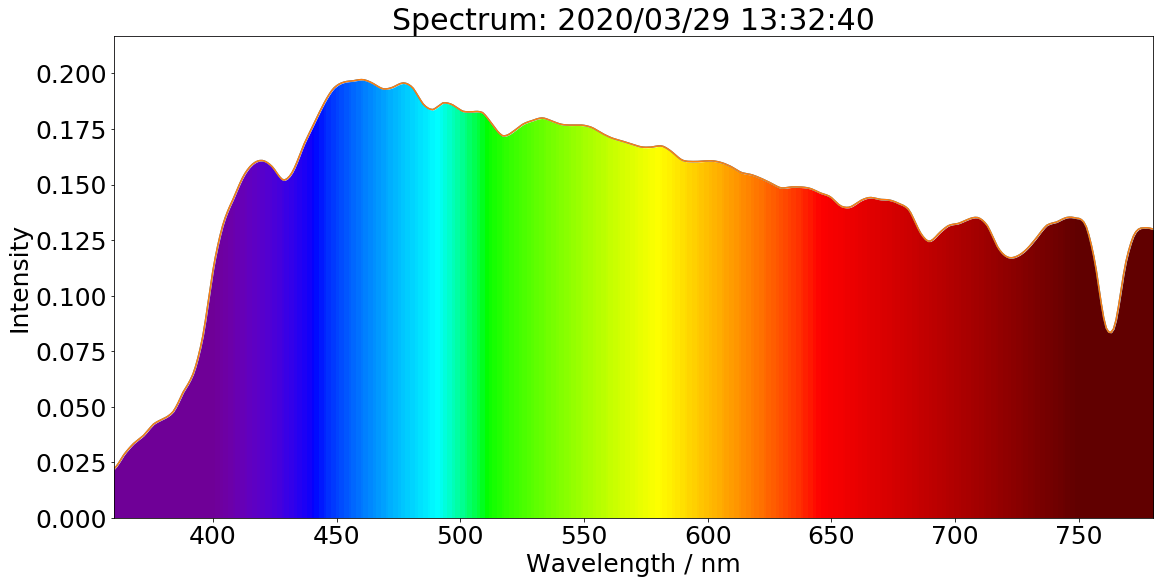

In [118]:
fig, ax = plt.subplots(constrained_layout=True, figsize=(16, 8))
plt.rcParams.update({'font.size': 25})
spectrum = Y1[0]
h = ax.plot(wavelengths, spectrum)

plt.plot(wavelengths, spectrum)

y2 = np.linspace(0, np.max(spectrum)*1.1, 100)

XX,YY = np.meshgrid(wavelengths, y2)
XX[XX<400] = 400
extent=(np.min(wavelengths), np.max(wavelengths), np.min(y2), np.max(y2))

plt.imshow(XX, clim=(350,780),  extent=extent, cmap=spectralmap, aspect='auto')
plt.fill_between(wavelengths, spectrum, np.max(spectrum)*1.1, color='w')

ax.set_title('Spectrum: %02d/%02d/%02d %02d:%02d:%02d' % (year, month, day, hour-jetlag, minute, second))
ax.set_xlabel('Wavelength / nm')
ax.set_ylabel('Intensity')

fig.savefig(dir_out+'Spectrum_%02d_%02d_%02d_%02d_%02d_%02d.png' % (year, month, day, hour-jetlag, minute, second))
#plt.close()

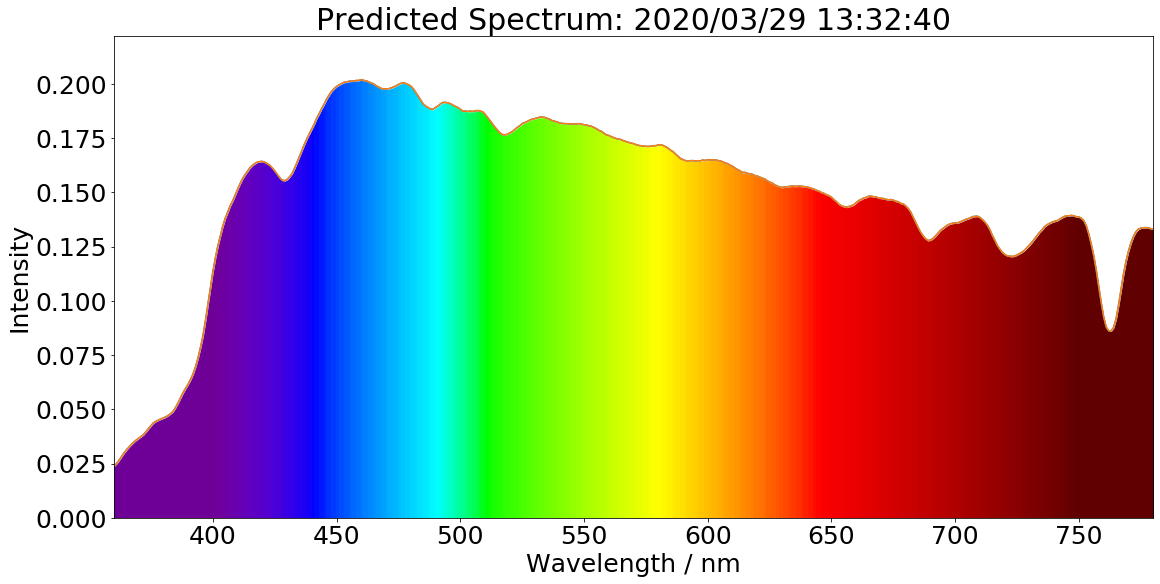

In [119]:
fig, ax = plt.subplots(constrained_layout=True, figsize=(16, 8))
plt.rcParams.update({'font.size': 25})
spectrum = Y1_pred[0]
h = ax.plot(wavelengths, spectrum)

plt.plot(wavelengths, spectrum)

y2 = np.linspace(0, np.max(spectrum)*1.1, 100)

XX,YY = np.meshgrid(wavelengths, y2)
XX[XX<400] = 400
extent=(np.min(wavelengths), np.max(wavelengths), np.min(y2), np.max(y2))

plt.imshow(XX, clim=(350,780),  extent=extent, cmap=spectralmap, aspect='auto')
plt.fill_between(wavelengths, spectrum, np.max(spectrum)*1.1, color='w')
ax.set_title('Predicted Spectrum: %02d/%02d/%02d %02d:%02d:%02d' % (year, month, day, hour-jetlag, minute, second))
ax.set_xlabel('Wavelength / nm')
ax.set_ylabel('Intensity')

fig.savefig(dir_out+'Spectrum_%02d_%02d_%02d_%02d_%02d_%02d_pred.png' % (year, month, day, hour-jetlag, minute, second))
#plt.close()

In [113]:
dir_out

'../figures/001e06305a6b/'

In [126]:
y = df['Illuminance']

In [135]:
len(X)

296938

In [133]:
time_start = time.time()
print(mutual_info_regression(X[:10000],y[:10000]))
print(time.time() - time_start)

[2.95675722 3.03997251 3.07280712 3.12346005 3.01652658 2.98851926
 1.68125582 2.07429644 1.69042372 2.87461456 2.87412356 1.37195039
 2.5295839  1.37273855 3.23585686 3.23314442 3.13694813 2.85243061
 1.66000669 2.61354137]
8.299760341644287


In [152]:
xx = np.random.rand(100000,3)

In [ ]:
time_start = time.time()
print(mutual_info_regression(X, df['Illuminance'], n_neighbors=3))
print(time.time()-time_start)

In [ ]:
time_start = time.time()
print(mutual_info_regression(X, df['Illuminance'], n_neighbors=30))
print(time.time()-time_start)

In [160]:
time_start = time.time()
print(mutual_info_regression(xx, xx[:,1], n_neighbors=30))
print(time.time()-time_start)

[8.51554860e-04 8.09514834e+00 2.36637399e-04]
20.282427549362183


In [161]:
time_start = time.time()
print(mutual_info_regression(xx, xx[:,1], n_neighbors=300))
print(time.time()-time_start)

[0.         5.80747222 0.        ]
63.93236231803894


In [12]:
from sklearn.feature_selection import mutual_info_regression